In [1]:
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Model, Sequential
from keras import models
from keras import layers
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from util.plots import plot_history
from nets.cnn_net.cnn_net import cnn_net
from glob import glob
import util.image_import as ii
import os
from keras.utils.np_utils import to_categorical
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


#### Trick to configure gpu memory dynamically

In [2]:
cfg = K.tf.ConfigProto() # Config to dynamically add memory
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))# set this TensorFlow session as the default session for Keras.

### Subtracting mean and normalizing

In [4]:
mean_image_train = ii.calulate_mean("../dataset3/res_still/train")

def subtract_mean(img):
    return img - mean_image_train

In [3]:
train_path = '../dataset3/res_still/train'
test_path = '../dataset3/res_still/test'

batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        vertical_flip=True,
        horizontal_flip=True,
        brightness_range=(0.65, 1.35),
        preprocessing_function=subtract_mean)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=subtract_mean)

# Train data generator
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=batch_size)

# Validation data generator
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=batch_size)

Found 1875 images belonging to 8 classes.
Found 472 images belonging to 8 classes.


In [5]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  #  3D activation map -> 1D vector
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5)) 
model.add(Dense(8))                                 
model.add(Activation('softmax'))                    
                                                    
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-3, epsilon=10e-8),
              metrics=['accuracy'])

### All classes with both types of catfood

In [6]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=1875 // batch_size,
            epochs=100,
            validation_data=test_generator,
            validation_steps=472 // batch_size,
            use_multiprocessing=True,
            workers=4)

Epoch 1/100
58/58 [==============================] - 45s 773ms/step - loss: 2.1556 - acc: 0.1489 - val_loss: 1.9847 - val_acc: 0.2031
Epoch 2/100
58/58 [==============================] - 45s 781ms/step - loss: 1.9240 - acc: 0.2359 - val_loss: 1.6911 - val_acc: 0.4085
Epoch 3/100
58/58 [==============================] - 49s 848ms/step - loss: 1.6469 - acc: 0.3605 - val_loss: 1.4374 - val_acc: 0.4933
Epoch 4/100
58/58 [==============================] - 49s 840ms/step - loss: 1.4612 - acc: 0.4351 - val_loss: 1.1590 - val_acc: 0.5223
Epoch 5/100
58/58 [==============================] - 46s 791ms/step - loss: 1.2886 - acc: 0.4899 - val_loss: 0.9980 - val_acc: 0.6362
Epoch 6/100
58/58 [==============================] - 42s 717ms/step - loss: 1.1584 - acc: 0.5371 - val_loss: 0.8210 - val_acc: 0.7388
Epoch 7/100
58/58 [==============================] - 42s 728ms/step - loss: 0.9669 - acc: 0.6215 - val_loss: 0.8461 - val_acc: 0.7299
Epoch 8/100
58/58 [==============================] - 42s 725ms

Epoch 62/100
58/58 [==============================] - 43s 748ms/step - loss: 0.3002 - acc: 0.8820 - val_loss: 0.2947 - val_acc: 0.9308
Epoch 63/100
58/58 [==============================] - 45s 770ms/step - loss: 0.4008 - acc: 0.8572 - val_loss: 0.2572 - val_acc: 0.9129
Epoch 64/100
58/58 [==============================] - 48s 824ms/step - loss: 0.2823 - acc: 0.8807 - val_loss: 0.2390 - val_acc: 0.9353
Epoch 65/100
58/58 [==============================] - 47s 806ms/step - loss: 0.3061 - acc: 0.8735 - val_loss: 0.2103 - val_acc: 0.9487
Epoch 66/100
58/58 [==============================] - 44s 751ms/step - loss: 0.3163 - acc: 0.8762 - val_loss: 0.1864 - val_acc: 0.9420
Epoch 67/100
58/58 [==============================] - 42s 723ms/step - loss: 0.2890 - acc: 0.8849 - val_loss: 0.2271 - val_acc: 0.9397
Epoch 68/100
58/58 [==============================] - 42s 729ms/step - loss: 0.2888 - acc: 0.8805 - val_loss: 0.2328 - val_acc: 0.9442
Epoch 69/100
58/58 [==============================] - 4

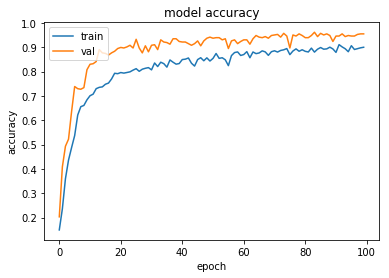

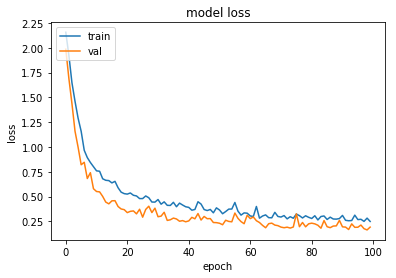

In [12]:
plot_history(history, save=False, path='nets/cnn_net/', name='cnn_multiclass')

In [10]:
model.save('CCN_multi_class.h5') 

### Not trained on catfood_beef
* Catfood beef and catfood salmon is in some picture identical so it is not possible to differentiate between the two, thus a model is trained without catfood beef

In [2]:
mean_image_train = ii.calulate_mean("../dataset3/res_still/train", ['catfood_beef'])

def subtract_mean(img):
    return img - mean_image_train

In [3]:
train_path = '../dataset3/res_still/train'
test_path = '../dataset3/res_still/test'

batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        vertical_flip=True,
        horizontal_flip=True,
        brightness_range=(0.65, 1.35),
        preprocessing_function=subtract_mean)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=subtract_mean)

# Train data generator
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        classes=['bun', 'carrots', 'ketchup', 'background', 'arm', 'catfood_salmon', 'potato'],
        batch_size=batch_size)

# Validation data generator
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        classes=['bun', 'carrots', 'ketchup', 'background', 'arm', 'catfood_salmon', 'potato'],
        batch_size=batch_size)

Found 1641 images belonging to 7 classes.
Found 413 images belonging to 7 classes.


In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  #  3D activation map -> 1D vector
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5)) 
model.add(Dense(7))                                 
model.add(Activation('softmax'))                    
                                                    
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-3, epsilon=10e-8),
              metrics=['accuracy'])

In [5]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=1641 // batch_size,
            epochs=100,
            validation_data=test_generator,
            validation_steps=347 // batch_size,
            use_multiprocessing=True,
            workers=4)

Epoch 1/100
51/51 [==============================] - 22s 426ms/step - loss: 2.0006 - acc: 0.1609 - val_loss: 1.8850 - val_acc: 0.2469
Epoch 2/100
51/51 [==============================] - 23s 445ms/step - loss: 1.8450 - acc: 0.1986 - val_loss: 1.6956 - val_acc: 0.2531
Epoch 3/100
51/51 [==============================] - 23s 453ms/step - loss: 1.7225 - acc: 0.2672 - val_loss: 1.4558 - val_acc: 0.4406
Epoch 4/100
51/51 [==============================] - 25s 498ms/step - loss: 1.5827 - acc: 0.3627 - val_loss: 1.2386 - val_acc: 0.4969
Epoch 5/100
51/51 [==============================] - 25s 482ms/step - loss: 1.3955 - acc: 0.4288 - val_loss: 1.0978 - val_acc: 0.5625
Epoch 6/100
51/51 [==============================] - 24s 475ms/step - loss: 1.3181 - acc: 0.4732 - val_loss: 1.0247 - val_acc: 0.5938
Epoch 7/100
51/51 [==============================] - 24s 464ms/step - loss: 1.1797 - acc: 0.5014 - val_loss: 0.8685 - val_acc: 0.6813
Epoch 8/100
51/51 [==============================] - 24s 476ms

Epoch 62/100
51/51 [==============================] - 25s 483ms/step - loss: 0.3184 - acc: 0.8624 - val_loss: 0.1706 - val_acc: 0.9500
Epoch 63/100
51/51 [==============================] - 24s 479ms/step - loss: 0.3343 - acc: 0.8657 - val_loss: 0.2338 - val_acc: 0.9344
Epoch 64/100
51/51 [==============================] - 24s 475ms/step - loss: 0.3286 - acc: 0.8596 - val_loss: 0.1596 - val_acc: 0.9688
Epoch 65/100
51/51 [==============================] - 25s 482ms/step - loss: 0.2765 - acc: 0.8857 - val_loss: 0.1499 - val_acc: 0.9719
Epoch 66/100
51/51 [==============================] - 25s 498ms/step - loss: 0.3258 - acc: 0.8615 - val_loss: 0.1328 - val_acc: 0.9688
Epoch 67/100
51/51 [==============================] - 26s 508ms/step - loss: 0.3084 - acc: 0.8648 - val_loss: 0.1800 - val_acc: 0.9656
Epoch 68/100
51/51 [==============================] - 27s 526ms/step - loss: 0.3057 - acc: 0.8694 - val_loss: 0.1164 - val_acc: 0.9688
Epoch 69/100
51/51 [==============================] - 2

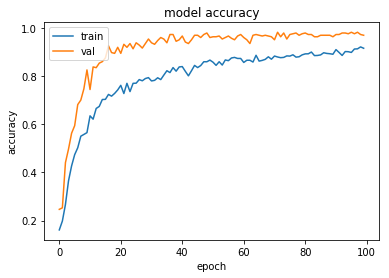

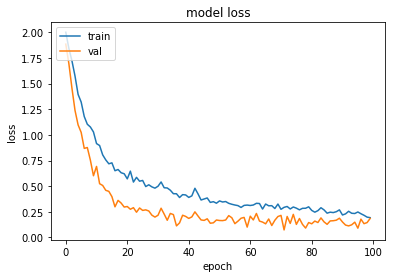

In [6]:
plot_history(history, save=False, path='nets/cnn_net/', name='cnn_multiclass')